In [2]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.stats import randint, uniform
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay,classification_report

### Load metadata

In [3]:
metadata = pd.read_csv("../metadata.csv", sep=";")

### Load features and labels

In [5]:
negative_serology = ["SRR22402286","SRR22402358","SRR22402336","SRR22402315","SRR22402330","SRR22402374","SRR22402370","SRR22402355","SRR22402353","SRR22402352","SRR22402351","SRR22402350","SRR22402349","SRR22402384","SRR22402297","SRR22402275","SRR22402318","SRR22402347","SRR22402383","SRR22402317","SRR22402304","SRR22402371","SRR22402264","SRR22402365","SRR22402369","SRR22402368","SRR22402367","SRR22402366","SRR22402364","SRR22402292","SRR22402299","SRR22402291","SRR22402305","SRR22402277","SRR22402270","SRR22402265","SRR22402259","SRR22402258","SRR22402327","SRR22402319","SRR22402310","SRR22402306","SRR22402303","SRR22402328","SRR22402332","SRR22402331","SRR22402266","SRR22402307","SRR22402333","SRR22402329"]
X = pd.read_csv("./features_species.csv", sep=";")
# filter out samples with negative TG serology
X = X.loc[~X["Sample"].isin(negative_serology)]
y = pd.read_csv("../labels.csv", sep=";")
y = y.loc[y["Sample"].isin(X["Sample"])].set_index("Sample", drop=True)["Label"]
X = X.set_index("Sample", drop=True)
X.shape

(122, 8889)

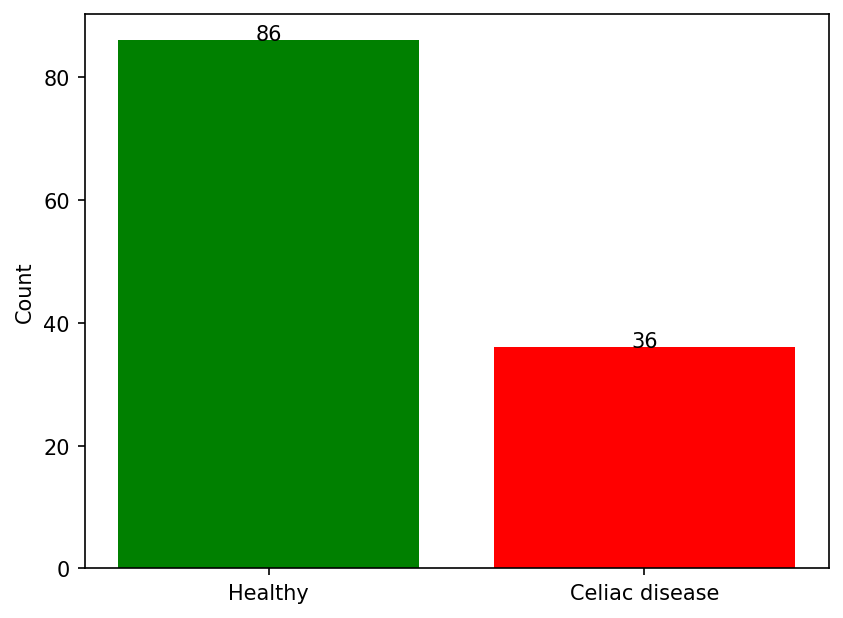

In [6]:
# Count the occurrences of each value
value_counts = y.value_counts()
plt.figure(dpi=150)
# Create the bar plot
plt.bar(value_counts.index, value_counts.values, color=['green', 'red'])

# Add labels to the bars
for i, v in enumerate(value_counts.values):
    plt.text(i, v, str(v), ha='center')

# Set the x-axis tick labels
plt.xticks(value_counts.index, ["Healthy", "Celiac disease"])


# Set the y-axis label
plt.ylabel('Count')

# Show the plot
plt.show()

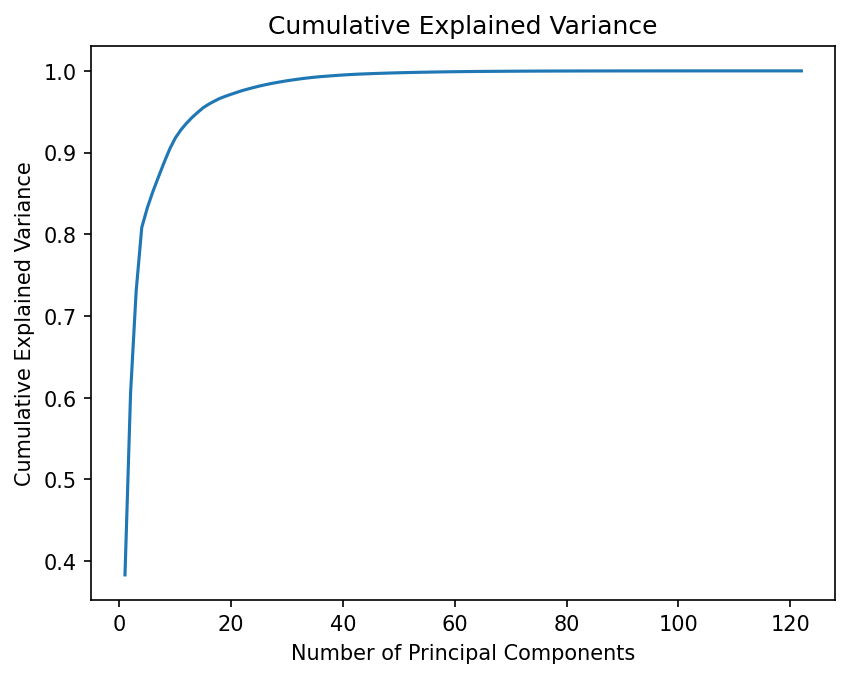

In [7]:
# Perform PCA
pca = PCA(random_state=42)
pca.fit(X)
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
fig = plt.figure(dpi=150)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

### Split the data into train and test

In [9]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Accuracy: 0.6
Best score:  0.8247368421052631
              precision    recall  f1-score   support

           0       0.68      0.76      0.72        17
           1       0.33      0.25      0.29         8

    accuracy                           0.60        25
   macro avg       0.51      0.51      0.50        25
weighted avg       0.57      0.60      0.58        25



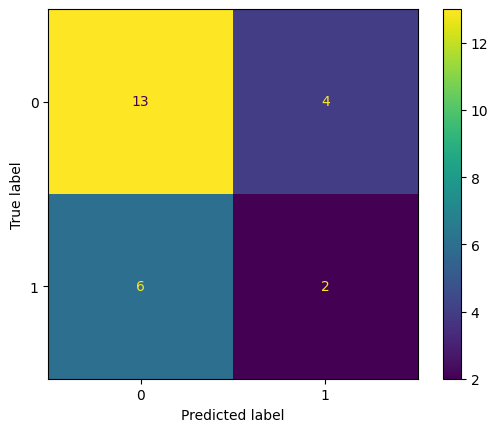

{'logreg__C': 0.2, 'pca__n_components': 8, 'variance_filter__threshold': 0}

In [10]:
pipeline = Pipeline([
    ('variance_filter', VarianceThreshold()),
    ('log_transform', FunctionTransformer(func=np.log1p, inverse_func=np.expm1)),
    ('min_max_scale', MinMaxScaler()),
    ('pca', PCA(random_state=42)),
    ('logreg', LogisticRegression(random_state=42, warm_start=True))
])
# define the hyperparameters to search over
param_grid = {
    'variance_filter__threshold': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
    'pca__n_components': [1,2,3,4,5,6,7,8,9,10],
    'logreg__C': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
}

# perform grid search to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)
# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)
# Get the best estimator and make predictions on the testing data
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)

# Compute accuracy for the best found RF
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print('Best score: ', grid_search.best_score_)
print(report)

cm = confusion_matrix(y_test, y_pred, labels=best_estimator.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_estimator.classes_)
disp.plot()
plt.show()
grid_search.best_params_